In [1]:
import matplotlib.pyplot as plt
import torch
import context
from models.diffusion import ForwardDiffusion
from torchvision.transforms import Resize, Normalize, Compose
from torchvision.io import read_image
import math
import pandas as pd

Nichol et al. "Improved DDPMs" found that linear schedule works well for high resolution images, but not so well for low resolutions such as 32x32. 

In [3]:
timesteps = 1000

dev = torch.device("cpu")

fwd_linear = ForwardDiffusion(timesteps=timesteps, type="linear", start=0.0001, end=0.02).to(dev)
fwd_cosine = ForwardDiffusion(timesteps=timesteps, type="cosine").to(dev)

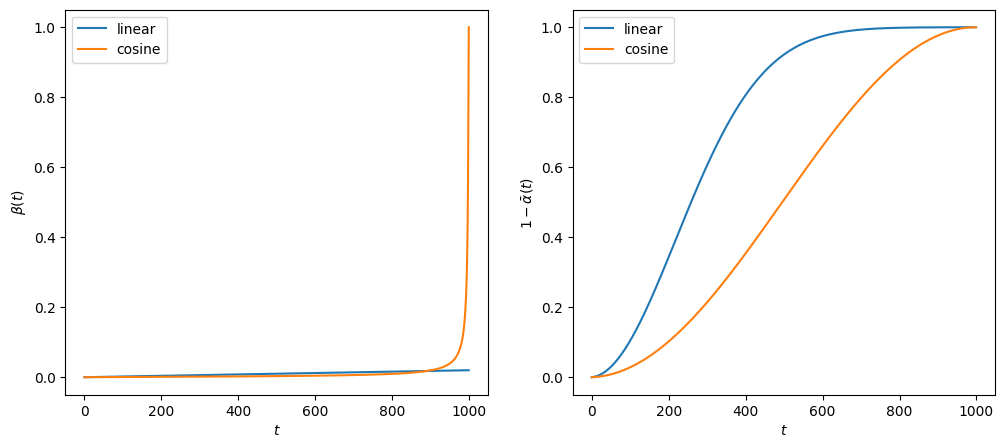

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(fwd_linear.betas.cpu(), label="linear")
ax[0].plot(fwd_cosine.betas.cpu(), label="cosine")
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$\beta(t)$")
ax[0].legend()
ax[1].plot(1 - fwd_linear.alphas_dash.cpu(), label="linear")
ax[1].plot(1 - fwd_cosine.alphas_dash.cpu(), label="cosine")
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$1 - \bar{\alpha}(t)$")
ax[1].legend()

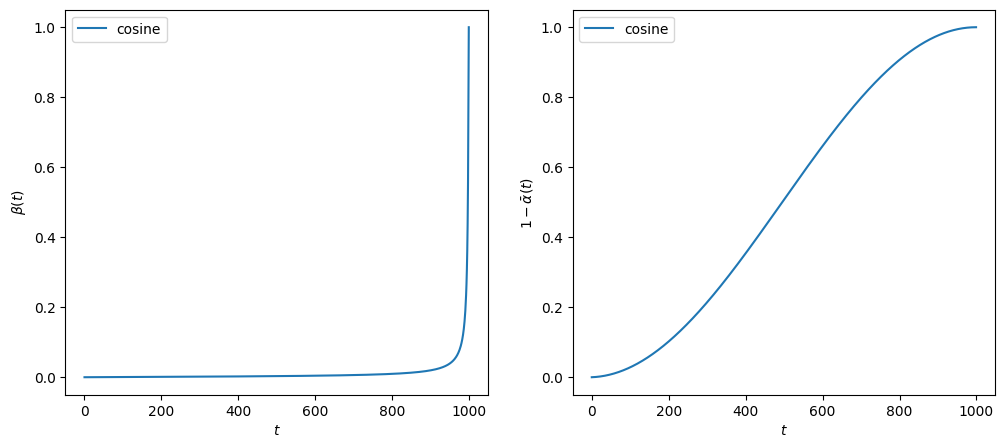

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
#ax[0].plot(fwd_linear.betas.cpu(), label="linear")
ax[0].plot(fwd_cosine.betas.cpu(), label="cosine")
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$\beta(t)$")
ax[0].legend()
#ax[1].plot(1 - fwd_linear.alphas_dash.cpu(), label="linear")
ax[1].plot(1 - fwd_cosine.alphas_dash.cpu(), label="cosine")
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$1 - \bar{\alpha}(t)$")
ax[1].legend()

In [60]:
img = "/Users/lionelpeer/Pictures/2020/Japan/darktable_exported/DSC_1808.jpg"
img = read_image(img) / 255
start = (1000, 1500)
transforms = [Resize((start[0]//(2**i), start[1]//(2**i))) for i in reversed(range(7))]
samples = []
for i in range(7):
    transform = Compose([Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms[i]])
    # sum the image channels
    samples.append(torch.sum(transform(img), dim=0).to(dev))

In [50]:
num_samples = 50

ts = []
for i in range(50):
    t = torch.tensor([20*i], dtype=torch.long, device=dev).unsqueeze(0).expand(num_samples,-1)
    ts.append(t)

all_lin = []
all_cos = []
for i, sample in enumerate(samples):
    all_lin.append([])
    all_cos.append([])
    sample = sample.unsqueeze(0).expand(num_samples, -1, -1, -1)
    for t in ts:
        # add noise
        x_lin, _ = fwd_linear(sample, t)
        x_cos, _ = fwd_cosine(sample, t)

        # calculate covariance matrix
        x_lin = torch.cov(x_lin.reshape(num_samples, -1))
        x_cos = torch.cov(x_cos.reshape(num_samples, -1))
        # get target matrix - identity matrix
        eye_lin = torch.eye(x_lin.shape[-1], device=dev)
        eye_cos = torch.eye(x_cos.shape[-1], device=dev)

        # get norm of difference
        x_lin = torch.mean(torch.abs(x_lin - eye_lin))
        x_cos = torch.mean(torch.abs(x_cos - eye_cos))

        all_lin[i].append(x_lin)
        all_cos[i].append(x_cos)
    print(f"{i} done")

0 done
1 done
2 done
3 done
4 done
5 done
6 done


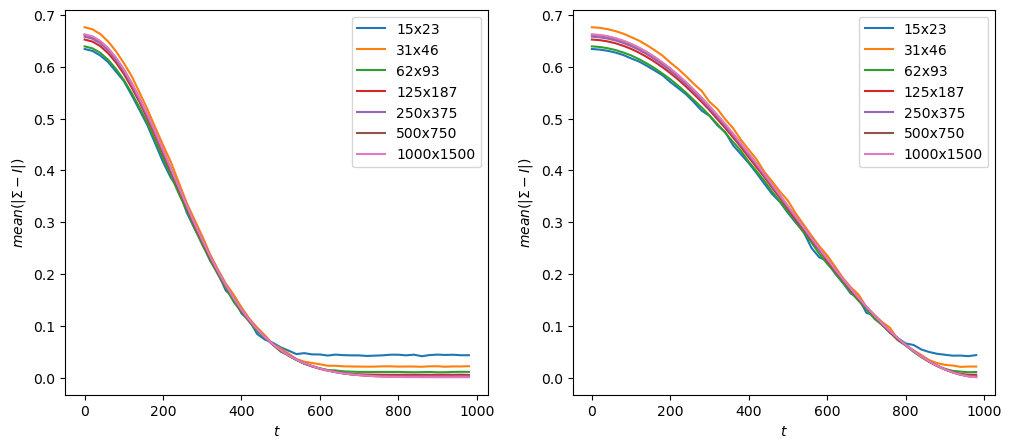

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
resolutions = [str(start[0]//(2**i)) + "x" + str(start[1]//(2**i)) for i in reversed(range(7))]
for i, tr in zip(range(len(all_lin)), transforms):
    ax[0].plot([20*i for i in range(50)], [elem.cpu() for elem in all_lin[i]], label=resolutions[i])
    ax[0].set_xlabel(r"$t$")
    ax[0].set_ylabel(r"$mean(|\Sigma - I|)$")
ax[0].legend()
for i in range(len(all_cos)):
    ax[1].plot([20*i for i in range(50)], [elem.cpu() for elem in all_cos[i]], label=resolutions[i])
    ax[1].set_xlabel(r"$t$")
    ax[1].set_ylabel(r"$mean(|\Sigma - I|)$")
ax[1].legend()